# Change point model for whole-building energy consumption

By Sang woo Ham (ecosang@gmail.com), Last edited on 09/12/2021

## Table of Contents

* [Introduction](#Introduction)
* [Change point model](#Change-point-model)
* [Building model](#Building-model)
* [Results](#Results)
* [Conclusion and discussion](#Conclusion-and-discussion)
* [References](#References)



# Introduction

Building energy efficiency has become an active research topic for decades. A building energy model is used to estimate the expected building energy consumption for various building design inputs such as insulation level, thermostat setpoints, etc. and 
has been an essential tool for building design, operation, and upgrade.

While the whole-building energy simulation program such as EnergyPlus is the most powerful for building design, it is time-consuming process to build the model as well as requires tremendous sensor data and engineering efforts to calibrate the simulation model for the real building.

For this reason, a data-driven model, derived from simplified building thermal dynamics, is widely used for the real building. This model is often used to estimate how much energy saving is achieved from the building retrofit. 

In this notebook, we will provide an example application of the data-driven model for the building retrofit. Based on a hypothetical building, we will create a building operation data. Then, we present how to use the data-driven model for the retrofitting application.

# Change point model

ASHRAE developed the Inverse Modeling Toolkit [1] to provide a framework to model the whole building energy consumption by using steady-state, linear, change-point linear, VBDD, and multivariate inverse models [2]. This simple and data-driven model has several advantages over complex building energy model [2]. First, the model is typically built based on data without human intervention (e.g., net electricity consumption and outdoor air temperature). Therefore, the development of this model can be automated in mulitple buildings or utility scale, and this can be used to identify buildings that show abnormally high energy consumption. In addition, the model is derived from a steady-state heat balance equation, so the model parameters can be interpreted as physical information such as setpoint temperature, building U-values, etc. This allows the modeler to identify if the building retrofit and its energy saving is achieved as designed. However, this type of model is developed based on steady-state heat balance (e.g., hourly, daily, weekly, or monthly data), so it is not suitable to capture dynamic thermal dynamics for peak demand management or control application.

One of the most popular model in the toolkit is change point model [1-4], which chracterizes heating and cooling energy consumption by using a whole building energy consumption and outdoor air temperature. There are variants in this model according to the availability of data period and characteristics of the heating and cooling system. But, for explanation purpose, we first derive the model based on a residential home with an electric heater. Then, the extension of this model is discussed in the discussion section.




Let's assume there is a box-type residential house. 

When the outdoor air temperature ($T_{\text{out},t_k}$ [$^\circ \text{C}$]) for some time period ($\Delta t$), the sensible heating load (${Q}_{\text{heat},t_k}$ [J]) to maintain the indoor air temperature setpoint ($T_{\text{set},t_k}$ [$^\circ \text{C}$]) for this period can be written as:

$${Q}_{\text{heat},t_k}=\left(T_{\text{set},t_k}-T_{\text{out},t_k}\right) \left( UA+ c_{p,\text{air}} \rho_{\text{air}} \dot{V}_{\text{out}} \right)\Delta t -\varepsilon_{Q_{\text{heat},t_k}} \Delta t,$$

where $t_k$ is discrete time index, $U$ is overall heat transfer coefficient of building exterior surfaces [$\text{W}/(\text{m}^2\cdot\text{K})$], $A$ is the overall area of building exterior surfaces [$\text{m}^2$],
 $\dot{V}_{\text{out}}$ [$\text{m}^3/\text{s}$] is the volumetric outdoor airflow rate coming into the indoor space from the outdoor due to infiltration and ventilation, $c_{p,\text{air}}$ [$\text{J}/(\text{kg} \cdot \text{K}   )$] is specific heat of air, $\rho_{\text{air}}$ [$\text{kg}/\text{m}^3$] is density of air, $\Delta t$ is time period, and $\varepsilon_{Q_{\text{heat},t_k}}$ is unmeasured heating load such as body heat gain, appliance loads, etc.

In this case, we only consider the heating load from the conductive heat transfer between outdoor and indoor air and ventilation/infiltration air, and the other factors such as solar heat gain, human/appliance heat gains, etc. are neglected.

Let's have there is an electric heater in the house to provide heating. Then, the electricity consumption ($E_{\text{heat},t_k}$ [J]) during $\Delta t$ is:

$$Q_{\text{heat},t_k}=\eta_{\text{heat}} E_{\text{heat},t_k},$$

where $\eta_{\text{heat}}$ is efficiency of electric heating device (e.g., COP of electric heat pump or efficieicny of electric heater). This is also a function of outdoor air temperature, but it is assumed to be constant for simplicity.

By coupling the two equation, it can be written as:

$$E_{\text{heat},t_k} = \frac{\Delta t}{\eta_\text{heat}} \left(T_{\text{set},t_k}-T_{\text{out},t_k}\right) \left( UA+ c_{p,\text{air}} \rho_{\text{air}} \dot{V}_{\text{out}} \right)-\frac{\Delta t}{\eta_\text{heat}}\varepsilon_{Q_{\text{heat},t_k}}  .$$

Let's write this term $\left( UA+ c_{p,\text{air}} \rho_{\text{air}} \dot{V}_{\text{out}} \right)$ as heating coefficient ($HC$) because it is relatively indepedent to outdoor air temperature. Then, the above equation can be written as:

$$E_{\text{heat},t_k} =\beta_{0,\text{heat}}-\beta_{1,\text{heat}}T_{\text{out},t_k},$$ 

where $\beta_{0,\text{heat}}=\frac{\Delta t}{\eta_{\text{heat}}}\left(T_{\text{set},t_k}HC-\varepsilon_{Q_{\text{heat},t_k}}\right)$ and $\beta_{1,\text{heat}}=HC\frac{\Delta t}{\eta_{\text{heat}}}$. In reality, $\beta_{0,\text{heat}}$ and $\beta_{1,\text{heat}}$ are time-varying parameters. However, for the simplicity, they are assumed to be varying aroung certain constants. Therefore, in this the simplest data-driven model, they are often assumed to fixed parameters.



When outdoor air temperature is mild (e.g., $T_{\text{out},t_k} \geq 15  ^\circ \text{C}$), it is often there is zero heating energy consumption. Then, this can be written as:

$$E_{\text{heat},t_k} =\beta_{1,\text{heat}}\left(\frac{\beta_{0,\text{heat}}}{\beta_{1,\text{heat}}}-T_{\text{out},t_k} \right)^{+},$$

where $()^{+}$ is $0$ when the value in $()$ is less than $0$.

Finally, if we assume that the non-heating electricity consumption for a certain time period ($E_{\text{non-heat},t_k}$) is relatively indepedent to the outdoor air temperature and follows a normal distribution ($E_{\text{non-heat},t_k} \sim \text{N}(\mu_{E_{\text{non-heat}}},\sigma_{\text{non-heat}}$), the total electricity consumption in this house ($E_{\text{total},t_k}$) can be written as:

$$ E_{\text{total},t_k} =E_{\text{non-heat},t_k} +\beta_{1,\text{heat}} \left(\frac{\beta_{0,\text{heat}}}{\beta_{1,\text{heat}}}-T_{\text{out},t_k} \right)^{+}.$$

Now, this is a piecewise linear regression model with three parameters (also called change point model [1]). But, in the real-data set, we can include a noise variable (including both of $E_{\text{total},t_k} \, \text{and}\, E_{\text{non-heat},t_k}$) by using a normal distribution ($\varepsilon_{t_k} \sim \text{N}(\mu_{\varepsilon},\sigma_{\varepsilon})$).

$$ E_{\text{total},t_k} =\beta_0 +\beta_{1} \left(\beta_2-T_{\text{out},t_k} \right)^{+}+\varepsilon_{t_k}.$$

# Building model

To understand the physical meanings of the model parameters, let's create hypothetical buildings with different building characteristics. For the simplicity, let's assume a box-type residential house as shown in below.






![house](../misc/house_.png)

Some parameters ($A$, $\dot{V}_\text{out}$, and $\Delta t$) are fixed. Different cases of buildings have different parameters values as shown in below.

|Case |$U$ \[$\text{W}$/ ($\text{m} ^2 K$)\]  | $\eta_\text{heat}$ \[ - \] | $T_\text{set}$[$^\circ \text{C}$]| 
|-----|---|-|-|
|case1|0.15|3.|20|
|case2|0.3|3.|20|
|case3|0.15|1.5|20|
|case4|0.15|3.|25|

where $U$ is overall heat transfer coefficient of building exterior surfaces [$\text{W}/(\text{m}^2\cdot\text{K})$], $A$ is the overall area of building exterior surfaces [$\text{m}^2$], $\eta_{\text{heat}}$ is efficiency of electric heating device (i.e., COP of electric heat pump), and $T_{\text{set},t_k}$ is the indoor air temperature setpoint [$^\circ \text{C}$].

The hourly outdoor air temperature ($T_\text{out}$) data is preprocessed from TMY3 dataset can be obtained from Energyplus [USA_IL_Chicago-OHare.Intl.AP.725300](https://energyplus.net/weather-region/north_and_central_america_wmo_region_4/USA/IL/Chicago-OHare%20Intl%20AP%20725300%20%28TMY3%29).

In [1]:
# loading required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # visualization
%matplotlib inline

In [2]:
# loading weather data
weather=pd.read_csv("../data/hourly_weather.csv")
# filter only heating and intermediate season data (Jan, Feb, Mar, Apr, May, Sep, Oct, Nov, Dec)
weather=weather[((weather['month']<=5) | (weather['month']>=9))]
T_out=weather['T_out'].to_numpy()
weather.head(3)

,timestamp,T_out,month
0,2021-01-01 00:00:00,-12.2,1
1,2021-01-01 01:00:00,-11.7,1
2,2021-01-01 02:00:00,-11.1,1


A function that simulate heating energy consumption of a building based on the eqauations above. Some values are assumed for examples. See comments in the function.

In [3]:
def building_model_heating(T_out,U,eta_heat,T_set,A=192,V_out=96/3600,delta_t=3600,epsilon_Q_heat=250,mu_E_non_heat=500,sigma_E_non_heat=20,seed_num=1234):
    cp_air=1.005 #J/(g.K)
    rho_air=1200 #g/m3 
    n_data=T_out.shape[0] # numper of data
    # negative values to positive values, epsilon_Q_heat default value is 250 W
    E_heat=np.fmax(0,delta_t/eta_heat*((T_set-T_out)*(U*A+cp_air*rho_air*V_out)-epsilon_Q_heat)) 
    np.random.seed(seed_num) # for reproducibility
    # E_non-heat ~ N(500,20) [Watt]. also np.abs() for all positive vlaues
    E_non_heat=np.abs(np.random.normal(mu_E_non_heat,sigma_E_non_heat,n_data))*delta_t
    E_total=E_heat+E_non_heat # unit: Joule
    return E_total

Let's calculate total electricity consumption. Function inputs are based on the cases presented above. After calculating the electricity, it is divided by (3600s x 1000) to represent as daily power demand in kW.

In [4]:
# calculate Electricity consumption for each case.
E_total_case1=building_model_heating(T_out=T_out,U=0.15,eta_heat=3.,T_set=20)/3600/1000 #[kW]
E_total_case2=building_model_heating(T_out=T_out,U=0.3,eta_heat=3.,T_set=20)/3600/1000 #[kW]
E_total_case3=building_model_heating(T_out=T_out,U=0.15,eta_heat=1.5,T_set=20)/3600/1000 #[kW]
E_total_case4=building_model_heating(T_out=T_out,U=0.15,eta_heat=3.,T_set=25)/3600/1000 #[kW]

Fit piecewise linear regression models (i.e., change point models).

In [5]:
# Piecewise linear regression model (change point model)
# loading package
from scipy import optimize

def piecewise_linear(x, beta0, beta1, beta2):
    condlist = [x < beta2,  x >= beta2] # x<beta3 applies to lambda x: beta0+beta1*x. 
    funclist = [lambda x: beta0+beta1*(x-beta2), lambda x:beta0 ]
    return np.piecewise(x, condlist, funclist) 

# estimate theta* and covariance of theta*
theta_case1 , theta_cov_case1 = optimize.curve_fit(piecewise_linear, T_out, E_total_case1) #least square
theta_case2 , theta_cov_case2 = optimize.curve_fit(piecewise_linear, T_out, E_total_case2) #least square
theta_case3 , theta_cov_case3 = optimize.curve_fit(piecewise_linear, T_out, E_total_case3) #least square
theta_case4 , theta_cov_case4 = optimize.curve_fit(piecewise_linear, T_out, E_total_case4) #least square

Since we generate the data from the model, it is not necessary to check the goodness-of-fit for this model. However, in real world application, we fit the model for the measured data. Specifically, in ASHRAE Guideline 14-2014 [2], there are several types of models that can be used to explain the data as shown in below figure. One can find the most suitable model through visual inspection but also use a specific numerical metric. 

![models](../misc/models.png)

The regression model's performance is often measured by $R^2$ value. But $\text{CV(RMSE)}$ is generally used to determine the suitability of the data according to ASHRAE Guideline 14-2014 [2]. 

According to the guideline, $\text{CV(RMSE)}$ measures:

>*An indication of how much variation or randomness there is between the data and the model, calculated by dividing RMSE by the average energy use.*


The guideline also suggests an advice for the acceptable $CV(RMSE)$ value for this application. 

>*The baseline model shall have a maximum CV(RMSE) of 20% for energy use and 30% for demand quantities when less than 12 months’ worth of postretrofit data are avail- able for computing savings. These requirements are 25% and 35%, respectively, when 12 to 60 months of data will be used in computing savings. When more than 60 months of data will be available, these requirements are 30% and 40%, respectively.*


In our case, we use less than 12 months of data, so we will use a maximum $\text{CV(RMSE)}$ of $20\%$ for energy use for the goodness-of-fit metric.

$R^2$ and $\text{CV(RMSE)}$ can be calculated as follows:


$$R^2=1-\frac{\sum_{i}^n{\left(y_i-\hat{y}_i\right)^2}}{ \sum_{i}^n{\left(y_i-\bar{y_{1:n}}\right)^2} },$$

$$\text{CV(RMSE)}=\frac{1}{\bar{y_{1:n}}}\sqrt{\frac{\left(y_i-\hat{y}_i\right)^2}{n-p}},$$

where $y_i$ is observed data, $i$ is data points ($1,2,..,n$), $\hat{y}_i$ is predicted through the piecewise linear regression model, $n$ is number of data, $p$ is number of parameters, $\bar{y_{1:n}}$ is average of data (i.e., $\frac{\sum_{i}^{n}{y}}{n}$). Below function calculates the both metrics.

In [6]:
def result_metrics(T_out,E_total,theta):
    y=E_total
    x=T_out
    y_hat=piecewise_linear(T_out, *theta)
    n=T_out.shape[0]
    p=theta.shape[0]
    y_bar=np.mean(y)
    R2=1-np.sum((y-y_hat)**2)/np.sum((y-y_bar)**2)
    #print(R2)
    CV_RMSE=1/y_bar*np.sqrt(np.sum((y-y_hat)**2)/(n-p))
    #print(CV_RMSE)
    return R2,CV_RMSE

#R2 CV(RMSE)


In [7]:
# calculate R2 and CV(RMSE)
R2_case1,CV_RMSE_case1=result_metrics(T_out,E_total_case1,theta_case1)
R2_case2,CV_RMSE_case2=result_metrics(T_out,E_total_case2,theta_case2)
R2_case3,CV_RMSE_case3=result_metrics(T_out,E_total_case3,theta_case3)
R2_case4,CV_RMSE_case4=result_metrics(T_out,E_total_case4,theta_case4)

# Results

Visualize simulated data and piecewise linear regression models.


(0, 2)

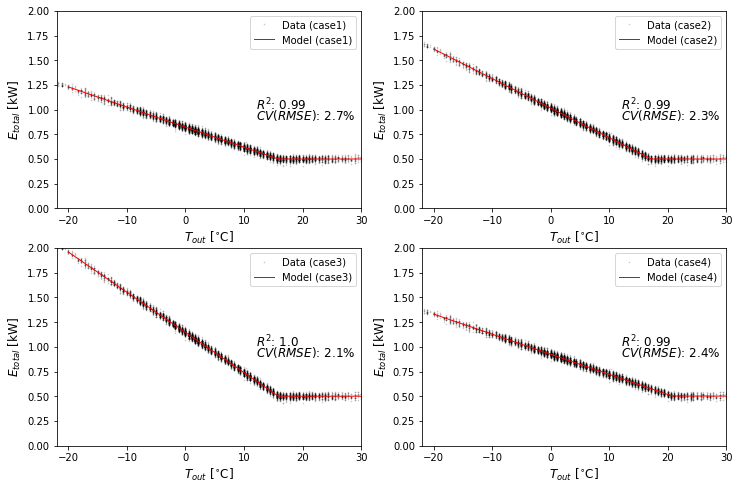

In [8]:
T_out_grid=np.linspace(-20,30,101)
fig, ax =plt.subplots(nrows=2, ncols=2,  figsize=(12,8))
ax[0,0].plot(T_out, E_total_case1, "kx",label="Data (case1)",markersize=1,alpha=0.2)
ax[0,0].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case1),'r-',label='Model (case1)',linewidth=1.0)
ax[0,0].legend(fontsize=10,loc="best")
ax[0,0].set_xlabel("$T_{out}$ [${^{\circ}}$C]",fontsize=12)
ax[0,0].set_ylabel("$E_{total}$ [kW]",fontsize=12)
ax[0,0].text(12, 1.0, f'$R^2$: {round(R2_case1,2)}', fontsize=12)
ax[0,0].text(12, 0.9, f'$CV(RMSE)$: {round(CV_RMSE_case1*100,1)}%', fontsize=12)
ax[0,0].set_xlim([-22,30])
ax[0,0].set_ylim([0,2])

ax[0,1].plot(T_out, E_total_case2, "kx",label="Data (case2)", markersize=1,alpha=0.2)
ax[0,1].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case2),'r-',label='Model (case2)',linewidth=1.0)
ax[0,1].legend(fontsize=10,loc="best")
ax[0,1].set_xlabel("$T_{out}$ [${^{\circ}}$C]",fontsize=12)
ax[0,1].set_ylabel("$E_{total}$ [kW]",fontsize=12)
ax[0,1].text(12, 1.0, f'$R^2$: {round(R2_case2,2)}', fontsize=12)
ax[0,1].text(12, 0.9, f'$CV(RMSE)$: {round(CV_RMSE_case2*100,1)}%', fontsize=12)
ax[0,1].set_xlim([-22,30])
ax[0,1].set_ylim([0,2])

ax[1,0].plot(T_out, E_total_case3, "kx",label="Data (case3)", markersize=1,alpha=0.2)
ax[1,0].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case3),'r-',label='Model (case3)',linewidth=1.0)
ax[1,0].legend(fontsize=10,loc="best")
ax[1,0].set_xlabel("$T_{out}$ [${^{\circ}}$C]",fontsize=12)
ax[1,0].set_ylabel("$E_{total}$ [kW]",fontsize=12)
ax[1,0].text(12, 1.0, f'$R^2$: {round(R2_case3,2)}', fontsize=12)
ax[1,0].text(12, 0.9, f'$CV(RMSE)$: {round(CV_RMSE_case3*100,1)}%', fontsize=12)
ax[1,0].set_xlim([-22,30])
ax[1,0].set_ylim([0,2])


ax[1,1].plot(T_out, E_total_case4, "kx",label="Data (case4)",markersize=1,alpha=0.2)
ax[1,1].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case4),'r-',label='Model (case4)',linewidth=1.0)
ax[1,1].legend(fontsize=10,loc="best")
ax[1,1].set_xlabel("$T_{out}$ [${^{\circ}}$C]",fontsize=12)
ax[1,1].set_ylabel("$E_{total}$ [kW]",fontsize=12)
ax[1,1].text(12, 1.0, f'$R^2$: {round(R2_case4,2)}', fontsize=12)
ax[1,1].text(12, 0.9, f'$CV(RMSE)$: {round(CV_RMSE_case4*100,1)}%', fontsize=12)
ax[1,1].set_xlim([-22,30])
ax[1,1].set_ylim([0,2])


In the above figure, all four cases are successfully modeled by the piecewise regression models (change point models). Since we generated data from the model, they are all showing good R2 and CV(RMSE) values.

In [9]:
pd.DataFrame(data={"cases":np.array(["case1","case2","case3","case4"]),
                   "U":np.array([0.15,0.3,0.15,0.15]),
                   "eta_heat":np.array([3,3,1.5,3]),
                   "T_set":np.array([20,20,20,25]),
                  "beta0":np.array([theta_case1[0],theta_case2[0],theta_case3[0],theta_case4[0]]),
                  "beta1":np.array([theta_case1[1],theta_case2[1],theta_case3[1],theta_case4[1]]),
                  "beta2":np.array([theta_case1[2],theta_case2[2],theta_case3[2],theta_case4[2]])})

,cases,U,eta_heat,T_set,beta0,beta1,beta2
0,case1,0.15,3.0,20,0.500696,-0.020319,15.881507
1,case2,0.30,3.0,20,0.500873,-0.029922,17.195168
2,case3,0.15,1.5,20,0.500696,-0.040639,15.890229
3,case4,0.15,3.0,25,0.502016,-0.020331,20.804151


Text(0.5, 0, '$T_{out}$ [${^{\\circ}}$C]')

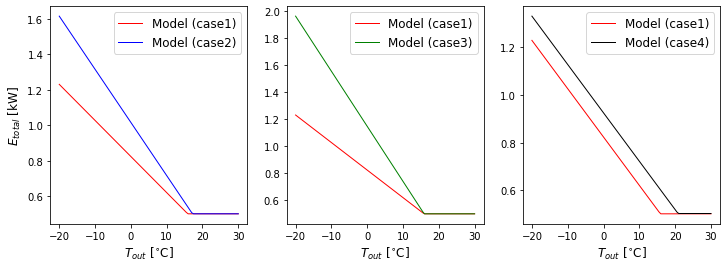

In [10]:
fig, ax =plt.subplots(nrows=1, ncols=3,  figsize=(12,4))
ax[0].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case1),'r-',label='Model (case1)',linewidth=1.0)
ax[0].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case2),'b-',label='Model (case2)',linewidth=1.0)
ax[0].legend(fontsize=12,loc="best")
ax[0].set_xlabel("$T_{out}$ [${^{\circ}}$C]",fontsize=12)
ax[0].set_ylabel("$E_{total}$ [kW]",fontsize=12)

ax[1].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case1),'r-',label='Model (case1)',linewidth=1.0)
ax[1].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case3),'g-',label='Model (case3)',linewidth=1.0)
ax[1].legend(fontsize=12,loc="best")
ax[1].set_xlabel("$T_{out}$ [${^{\circ}}$C]",fontsize=12)
#ax[1].set_ylabel("$E_{total}$ [kW]",fontsize=12)

ax[2].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case1),'r-',label='Model (case1)',linewidth=1.0)
ax[2].plot(T_out_grid, piecewise_linear(T_out_grid, *theta_case4),'k-',label='Model (case4)',linewidth=1.0)
ax[2].legend(fontsize=12,loc="best")
ax[2].set_xlabel("$T_{out}$ [${^{\circ}}$C]",fontsize=12)
#ax[2].set_ylabel("$E_{total}$ [kW]",fontsize=12)

In the above figure, the change point models of different cases are compared. 

1. In the first figure, case1 and case2 are compared. Case2 has high value in $U$, and this results in a steeper slope. They also show different change points though they have same setpoints. The reason is the change point is also affected by both $U$ and $T_{\text{set}}$ values. 

2. In the second figure, case1 and case3 are compared. In this case, the only difference of the two cases is the efficiency of the heater. It results in steeper slope for case 3 with same change point.

3. In the third figure, case1 and case4 are compared. In this case, case4 have higher heating setpoint, and this results in the increase of change point. 

# Conclusion and discussion

In this notebook, we present the derviation of change point model based on steady-state heat balance model. We generate the data from the model and present how to fit the model with the data and evaluatlion metrics. The model works as designed and shows good performances. In addition, we can understand how the building parameters affect the change point model. In other words, we can infer whether the building retrofit has worked as expected. Furthermore, we can compare models of different buildings to see which building has a thermally better performance. However, in real world data, it is difficult to know which factors make a better performance because there are various unobserved parts (such as human activity), assumptions for time-varying parameters (e.g., heating efficiency), and noises. While this approach is a fast and convenient way to evaluate the building's thermal performance, there are rooms to improve this model to make a better inference by including missing factors in this model's assumptions.

# References

[1] Kissock, J. K., Haberl, J. S., & Claridge, D. E. (2003). Inverse modeling toolkit: numerical algorithms. ASHRAE transactions, 109, 425. [(link)](http://www.eeperformance.org/uploads/8/6/5/0/8650231/ashrae_-_inverse_modeling_toolkit_-_numerical_algorithms.pdf)

[2] ASHRAE. (2014). ASHRAE Guideline 14–2014, Measurement of Energy, Demand, and Water Savings. [(link)](https://www.techstreet.com/standards/guideline-14-2014-measurement-of-energy-demand-and-water-savings?product_id=1888937)

[3] Server, F., Kissock, J. K., Brown, D., & Mulqueen, S. (2011). Estimating industrial building energy savings using inverse simulation. [(link)](https://ecommons.udayton.edu/cgi/viewcontent.cgi?article=1155&context=mee_fac_pub)